In [2]:
import pickle
import networkx as nx

# load model from file
model = pickle.load(open("../models/model.xgb", "rb"))

df = model.trees_to_dataframe()

# Create graph
G = nx.Graph()
# Add all the nodes
G.add_nodes_from(df.ID.tolist())
# Add the edges. This should be simpler in Pandas, but there seems to be a bug with df.apply(tuple, axis=1) at the moment.
yes_pairs = df[['ID', 'Yes']].dropna()
no_pairs = df[['ID', 'No']].dropna()
yes_edges = [tuple([i[0], i[1]]) for i in yes_pairs.values]
no_edges = [tuple([i[0], i[1]]) for i in no_pairs.values]
G.add_edges_from(yes_edges + no_edges)

In [3]:
df

Tree  Node     ID Feature       Split  Yes    No Missing          Gain  \
0         0     0    0-0      f1  127.500000  0-1   0-2     0-1  2.176386e+01   
1         0     1    0-1      f7   28.500000  0-3   0-4     0-3  5.160563e+00   
2         0     2    0-2      f5   28.150000  0-5   0-6     0-5  6.173975e+00   
3         0     3    0-3      f5   30.950001  0-7   0-8     0-7  8.211861e-01   
4         0     4    0-4      f5   26.350000  0-9  0-10     0-9  3.434854e+00   
...     ...   ...    ...     ...         ...  ...   ...     ...           ...   
50657   495     0  495-0    Leaf         NaN  NaN   NaN     NaN  1.179312e-10   
50658   496     0  496-0    Leaf         NaN  NaN   NaN     NaN  1.139505e-10   
50659   497     0  497-0    Leaf         NaN  NaN   NaN     NaN  1.104108e-10   
50660   498     0  498-0    Leaf         NaN  NaN   NaN     NaN  1.068954e-10   
50661   499     0  499-0    Leaf         NaN  NaN   NaN     NaN  1.034639e-10   

       Cover  Category  
0      514.0       NaN  
1      332.0       NaN  
2      182.0       NaN  
3      193.0       NaN  
4      139.0       NaN  
...      ...       ...  
50657  514.0       NaN  
50658  514.0       NaN  
50659  514.0       NaN  
50660  514.0       NaN  
50661  514.0       NaN  

[50662 rows x 11 columns]

In [8]:
import xgboost

dump = model.get_dump(dump_format="json") # list with each being a tree

In [14]:
import json
tree = json.loads(dump[0])

In [21]:
tree['children'][0]['children'][0]['children'][0]

{'nodeid': 7,
 'depth': 3,
 'split': 'f0',
 'split_condition': 7.5,
 'yes': 15,
 'no': 16,
 'missing': 15,
 'children': [{'nodeid': 15, 'leaf': -0.0242990665},
  {'nodeid': 16, 'leaf': 0.0125000002}]}

In [29]:
model.save_model('model_file_name.json')

In [3]:
import networkx as nx

df = model.trees_to_dataframe()

G = nx.DiGraph()
G.add_nodes_from(df.ID.tolist())

yes_edges = df[['ID', 'Yes', 'Feature', 'Split']].dropna()
yes_edges['label'] = yes_edges.apply(lambda x: "({feature} > {value:.2f} or {feature} = 999999)".format(feature=x['Feature'], value=x['Split']), axis=1)

no_edges = df[['ID', 'No', 'Feature', 'Split']].dropna()
no_edges['label'] = no_edges.apply(lambda x: "({feature} < {value:.2f})".format(feature=x['Feature'], value=x['Split']), axis=1)

for v in yes_edges.values:
    G.add_edge(v[0],v[1], feature=v[2], expr=v[4])
    
for v in no_edges.values:
    G.add_edge(v[0],v[1], feature=v[2], expr=v[4])

leaf_node_values = {i[0]:i[1] for i in df[df.Feature=='Leaf'][['ID','Gain']].values}    
    
roots = []
leaves = []
for node in G.nodes :
    if G.in_degree(node) == 0 : # it's a root
        roots.append(node)
    elif G.out_degree(node) == 0 : # it's a leaf
        leaves.append(node)
        
paths = []
for root in roots :
    for leaf in leaves :
        for path in nx.all_simple_paths(G, root, leaf) :
            paths.append(path)

In [5]:
paths[1]

['0-0', '0-2', '0-5', '0-11']

In [9]:
dump = model.get_dump()

In [4]:
what = df.loc[df['Tree'] == 0]
what = what.loc[what['Feature'] == 'Leaf']
what

Tree  Node     ID Feature  Split  Yes   No Missing      Gain  Cover  \
9       0     9    0-9    Leaf    NaN  NaN  NaN     NaN -0.024074   26.0   
11      0    11   0-11    Leaf    NaN  NaN  NaN     NaN -0.021250   19.0   
15      0    15   0-15    Leaf    NaN  NaN  NaN     NaN -0.024299  106.0   
16      0    16   0-16    Leaf    NaN  NaN  NaN     NaN  0.012500    1.0   
29      0    29   0-29    Leaf    NaN  NaN  NaN     NaN -0.016667    2.0   
..    ...   ...    ...     ...    ...  ...  ...     ...       ...    ...   
140     0   140  0-140    Leaf    NaN  NaN  NaN     NaN -0.014286    6.0   
141     0   141  0-141    Leaf    NaN  NaN  NaN     NaN -0.019318   21.0   
142     0   142  0-142    Leaf    NaN  NaN  NaN     NaN -0.003125    7.0   
143     0   143  0-143    Leaf    NaN  NaN  NaN     NaN -0.016667    2.0   
144     0   144  0-144    Leaf    NaN  NaN  NaN     NaN  0.012500    1.0   

     Category  
9         NaN  
11        NaN  
15        NaN  
16        NaN  
29        NaN  
..        ...  
140       NaN  
141       NaN  
142       NaN  
143       NaN  
144       NaN  

[73 rows x 11 columns]

In [5]:
df['Feature'].unique()

array(['f1', 'f7', 'f5', 'f0', 'f6', 'Leaf', 'f4', 'f3', 'f2'],
      dtype=object)

In [19]:
model.num_features()

8

In [35]:
import pandas as pd
pd.options.display.max_rows = None

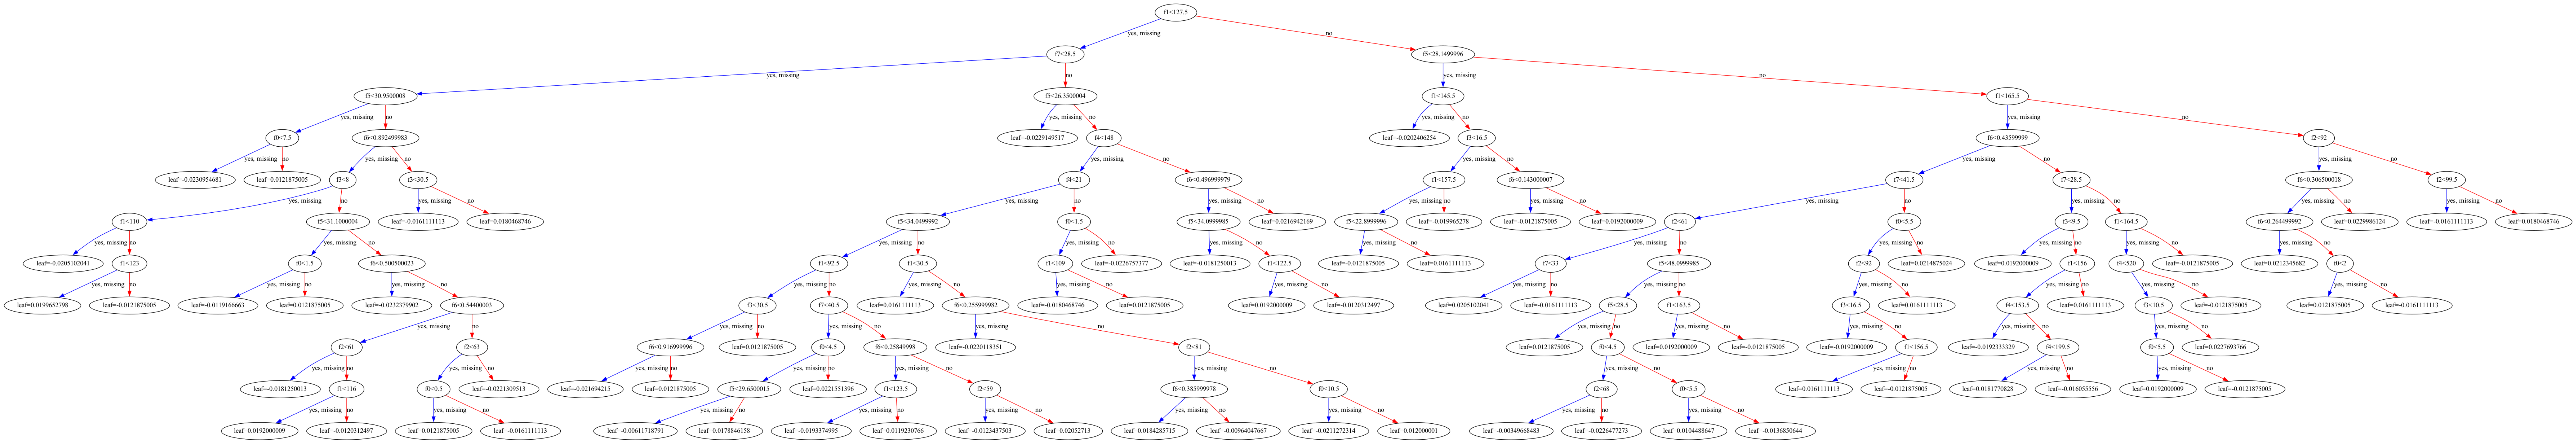

In [8]:
import xgboost as xgb
from xgboost import plot_tree
import matplotlib
from matplotlib import pyplot as plt

xgb.plot_tree(model, num_trees=1)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

In [ ]:
class DecisionTree:
    def __init__(self, tree_id, tree_dump):
        self.split = 0
        self.gain = 0
        self.
        self.yes = None
        self.no = None

In [ ]:
class DecisionTree:
    def __init__(self, tree_id, tree_dump):
        self.split = 0
        self.gain = 0
        self.cover = 0
        
        self.yes = None
        self.no = None